In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pathlib
# import matplotlib.pyplot as plt
from scipy import integrate
import gpflow

# Increase the size of the fonts in the plots
matplotlib.rcParams.update({"font.size": 14,
                            'text.usetex': True,
                            "text.latex.preamble": r"\usepackage{amsfonts}"})

2024-01-23 21:09:55.305017: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-23 21:09:55.405274: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-23 21:09:55.408465: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-01-23 21:09:55.408475: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not ha

In [2]:
seed = 0
np.random.seed(seed)
numpy_rng = np.random.RandomState(seed)

In [3]:
path_folder_figures = "/home/hosseinkhan/Documents/work/phd/latex_documents/2024_01_08_meca_slides/images"

In [4]:
# Create time series starting from a perturbed unstable equilibrium of the duffing oscillator
# and integrate it using scipy.integrate.odeint
alpha = 0.0
beta = 0.0
delta = 0.0
gamma = 0.0
omega = 0.0
nu = 1.0

dim_state = 2

# array_x0 = np.zeros(dim_state)
array_x0 = np.array([1, 0])

perturbation_std = 0.1
array_perturbation = numpy_rng.normal(0, perturbation_std, dim_state)

# Define the maximal iteration index and the time step
k_max = 200
dt = 0.05

array_x0 = array_x0 + array_perturbation


# noinspection PyUnusedLocal,PyShadowingNames
def ode(array_state, t, alpha, beta, delta, gamma, omega, nu):
    """
    Oscillator
    :param beta: 
    :param alpha: 
    :param omega: 
    :param gamma: 
    :param array_state: state vector
    :param t: time
    :param delta: parameter
    :return: derivative of the state vector
    """
    x1, x2 = array_state
    dx1_dt = x2
    dx2_dt = - beta * x1 ** 3 - alpha * x1 - delta * x2 + gamma * np.cos(omega * t) + nu * np.cos(x2)
    # dx2_dt = - beta * x1 ** 3 - alpha * x1 - delta * x2 + gamma * np.cos(omega * t) - (x1 ** 2 - 1) * x2
    return dx1_dt, dx2_dt


# Integrate the system
matrix_dynamics = integrate.odeint(ode,
                                   array_perturbation,
                                   np.arange(0, k_max * dt, dt),
                                   args=(alpha, beta, delta, gamma, omega, nu))


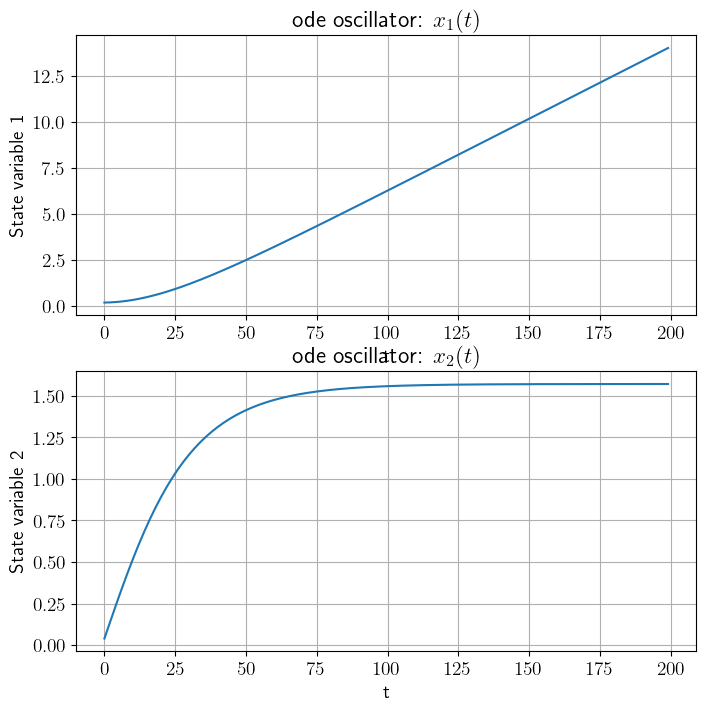

In [5]:
# Plot th
fig, axs = plt.subplots(dim_state, 1, figsize=(8, 8))

for i in range(dim_state):
    axs[i].plot(matrix_dynamics[:, i])
    axs[i].set_xlabel("t")
    axs[i].set_ylabel("State variable {}".format(i + 1))
    axs[i].grid(True)
    # Set the title of the plot
    axs[i].set_title("ode oscillator: $x_{}(t)$".format(i + 1))

del fig, axs

In [6]:
# Plot the vector field
period = 2
x1_min = - 1
x1_max = 1
x2_min = - 2 * np.pi * period
x2_max = 2 * np.pi * period
dx = 0.1
# Create a mesh
matrix_mesh_x1, matrix_mesh_x2 = np.meshgrid(np.arange(x1_min, (x1_max + dx), dx),
                                             np.arange(x2_min, (x2_max + dx), dx))
# Compute the vector field for the x, y component of the ode oscillator
matrix_df_dx1, matrix_df_dx2 = ode((matrix_mesh_x1, matrix_mesh_x2), 0, alpha, beta, delta, gamma, omega, nu)

In [7]:
test = ode((matrix_mesh_x1, matrix_mesh_x2), 0, alpha, beta, delta, gamma, omega, nu)

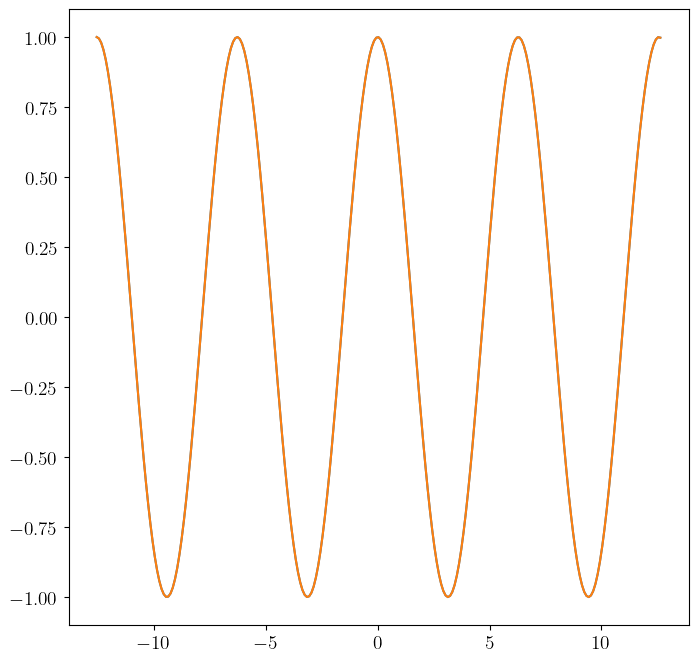

In [8]:
# Plot testsss
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
# noinspection PyRedeclaration
ax = plt.subplot(111)
ax.plot(test[0][:, 0], test[1][:, 0])
ax.plot(matrix_mesh_x2[:, 0], matrix_df_dx2[:, 0])

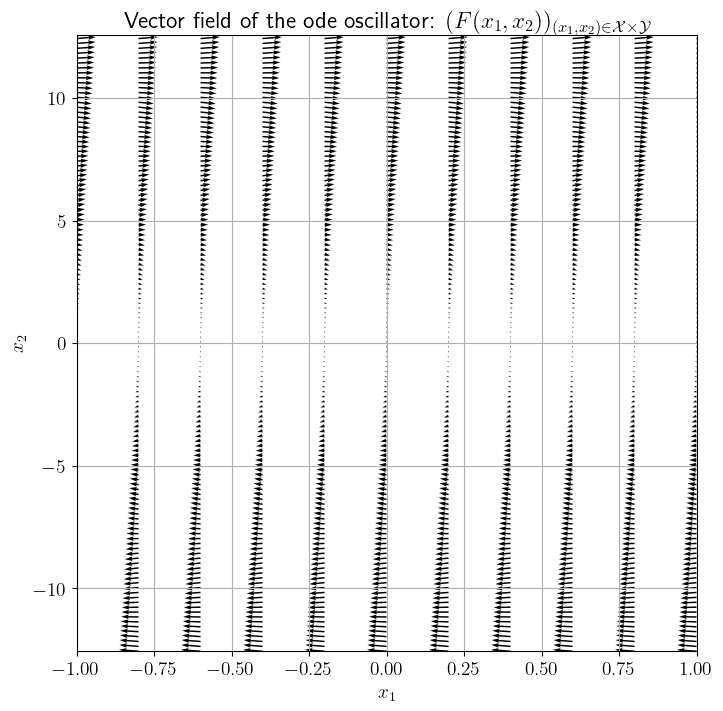

In [9]:
# Plot the vector field
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
spacing_arrow = 2
size_arrow = 3
ax.quiver(matrix_mesh_x1[::spacing_arrow, ::spacing_arrow],
          matrix_mesh_x2[::spacing_arrow, ::spacing_arrow],
          matrix_df_dx1[::spacing_arrow, ::spacing_arrow],
          matrix_df_dx2[::spacing_arrow, ::spacing_arrow],
          scale=400
          )
ax.set_xlabel(f"$x_1$")
ax.set_ylabel(f"$x_2$")
ax.set_xlim([x1_min, x1_max])
ax.set_ylim([x2_min, x2_max])
ax.grid(True)
# Title of the plot
ax.set_title(
    "Vector field of the ode oscillator: $(F(x_1, x_2))_{(x_1, x_2) \\in \\mathcal{X} \\times \\mathcal{Y}}$")
# Add a vertical line at x = 1
# ax.axvline(x=1, color='r', linestyle='--')ode_vector_field.png", dpi=300)
# Save figure to file
# Create the folder if it does not exist
path_folder_file = pathlib.Path(f"{path_folder_figures}/oscillator_vector_field")
pathlib.Path(path_folder_file).mkdir(parents=True, exist_ok=True)
# fig.savefig(f"{path_folder_figures}/oscillator_vector_field/"
#             f"oscillator_vector_field.png", dpi=300)
del fig, ax

In [10]:
# Generate 4 noisy vector fields from the vector field
# The first one being the original vector field
# The other ones being noisy versions of the original vector field
n_noisy_vector_fields = 4
array3d_df_dx1 = np.zeros((matrix_mesh_x1.shape[0], matrix_mesh_x1.shape[1], 4))
array3d_df_dx2 = np.zeros((matrix_mesh_x1.shape[0], matrix_mesh_x1.shape[1], 4))
# Add the original vector field
array3d_df_dx1[:, :, 0] = matrix_df_dx1
array3d_df_dx2[:, :, 0] = matrix_df_dx2

# Add the noisy vector fields
vector_field_noise_std = 1.0
for i in range(n_noisy_vector_fields - 1):
    array_noise_x1 = numpy_rng.normal(0, vector_field_noise_std, matrix_mesh_x1.shape)
    array_noise_x2 = numpy_rng.normal(0, vector_field_noise_std, matrix_mesh_x2.shape)
    array3d_df_dx1[:, :, i + 1] = matrix_df_dx1 + array_noise_x1
    array3d_df_dx2[:, :, i + 1] = matrix_df_dx2 + array_noise_x2


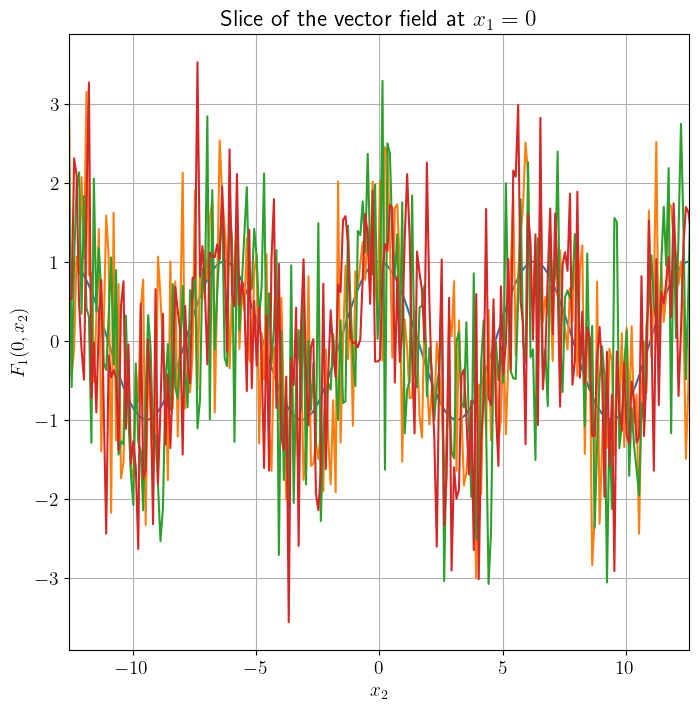

In [11]:
# Extracting the slice of the vector field at x = 1
# And store it in a 2D array
x1_slice = 0

array_df_dx1_slice = array3d_df_dx2[:, x1_slice, :]

# Plot the slice of the vector field
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
# noinspection PyRedeclaration
ax = plt.subplot(111)
ax.plot(matrix_mesh_x2[:, x1_slice], array_df_dx1_slice)
ax.set_xlabel(f"$x_2$")
ax.set_ylabel(f"$F_1({x1_slice}, x_2)$")
ax.set_xlim([x2_min, x2_max])
ax.grid(True)
# Title of the plot
ax.set_title("Slice of the vector field at $x_1 = {}$".format(x1_slice))
del fig, ax

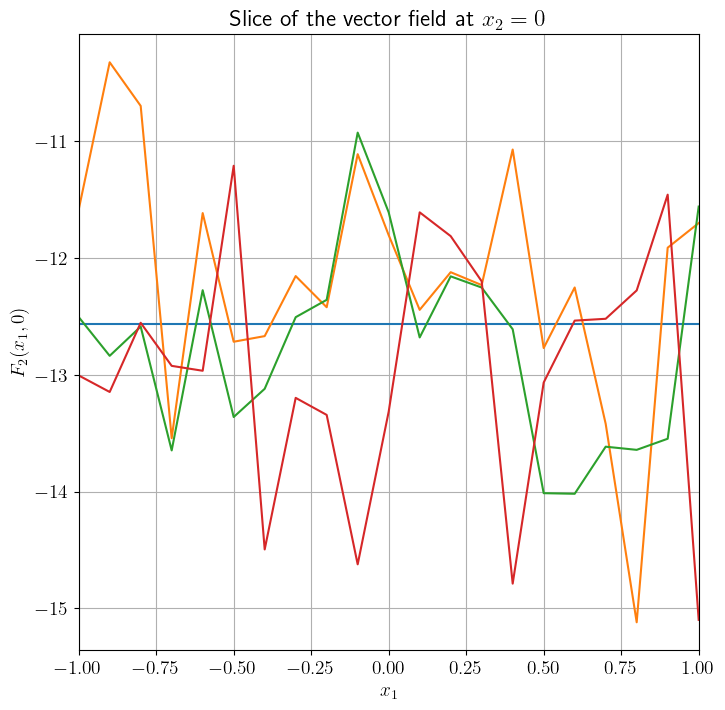

In [12]:
# Extracting the slice of the vector field at y = 1
# And store it in a 2D array
x2_slice = 0

array_df_dx2_slice = array3d_df_dx1[x2_slice, :, :]
# Plot the slice of the vector field
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
# noinspection PyRedeclaration
ax = plt.subplot(111)
ax.plot(matrix_mesh_x1[x2_slice, :], array_df_dx2_slice)
ax.set_xlabel(f"$x_1$")
ax.set_ylabel(f"$F_2(x_1, {x2_slice})$")
ax.set_xlim([x1_min, x1_max])
ax.grid(True)
# Title of the plot
ax.set_title("Slice of the vector field at $x_2 = {}$".format(x2_slice))
del fig, ax

### Gaussian process modeling

In [57]:
# Extract 10 points randomly from the x2 = 1 slice of the vector field
# to form a (X, Y) training set such that x_i is a mesh point 
# and y_i is the value of the vector field at x_i

# Fix the vector field from which we extract the training data
random_vector_field_id = 0
# Number of training points
n_training_points = 10
# Extract the training points
array_training_points_id = numpy_rng.choice(array_df_dx1_slice.shape[0], n_training_points, replace=False)
array_x1_training = matrix_mesh_x2[array_training_points_id, x1_slice]
array_y1_training = array_df_dx1_slice[array_training_points_id, random_vector_field_id]

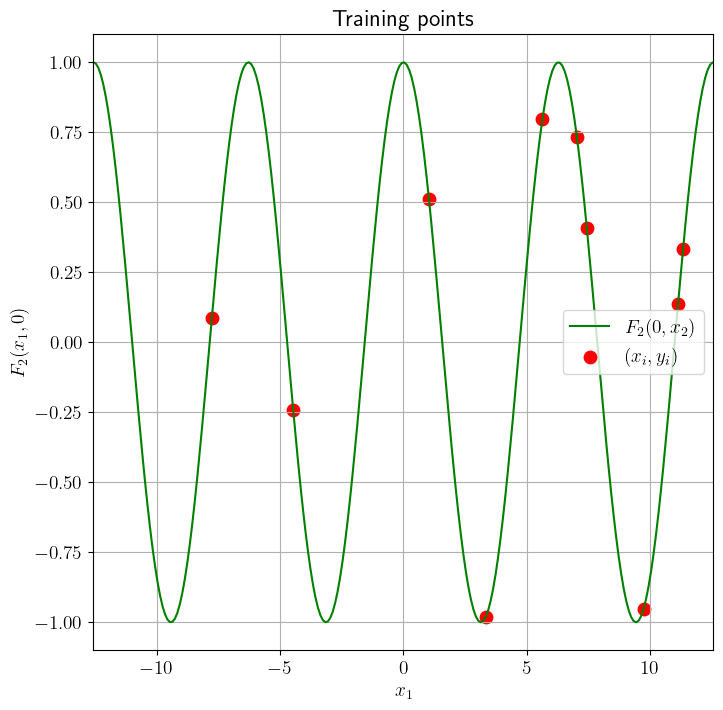

In [58]:
# Plot the training points
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
# noinspection PyRedeclaration
ax = plt.subplot(111)
ax.plot(matrix_mesh_x2[:, x1_slice],
        array_df_dx1_slice[:, random_vector_field_id],
        color="g",
        label="$F_2(0, x_2)$")
ax.scatter(array_x1_training,
           array_y1_training,
           color='r',
           s=80,
           label="$(x_i, y_i)$")
# Set the labels
ax.set_xlabel(f"$x_1$")
ax.set_ylabel(f"$F_2(x_1, {x1_slice})$")
ax.set_xlim([x2_min, x2_max])
ax.grid(True)
# Title of the plot
ax.set_title("Training points")
# Display the legend
ax.legend()

# Save figure to file
# Create the folder if it does not exist
path_folder_file = pathlib.Path(f"{path_folder_figures}/training_points")
pathlib.Path(path_folder_file).mkdir(parents=True, exist_ok=True)
# fig.savefig(f"{path_folder_figures}/training_points/"
#             f"training_points.png", dpi=300)

del fig, ax

In [59]:
model_prior = gpflow.models.GPR(
    data=(np.zeros((1, 1)), np.zeros((1, 1))),
    kernel=gpflow.kernels.SquaredExponential(),
    noise_variance=2 * 1e-6)

In [60]:
# Draw samples from the prior
n_samples_prior = 10
array3d_samples_prior = model_prior.predict_f_samples(matrix_mesh_x2[:, x1_slice, None],
                                                      num_samples=n_samples_prior).numpy()
# Get the mean and variance of the GP
array_f1_mean_prior, array_f1_var_prior = model_prior.predict_f(matrix_mesh_x2[:, x1_slice, None])

# Cast to numpy array
array_f1_mean_prior = array_f1_mean_prior.numpy()
array_f1_var_prior = array_f1_var_prior.numpy()

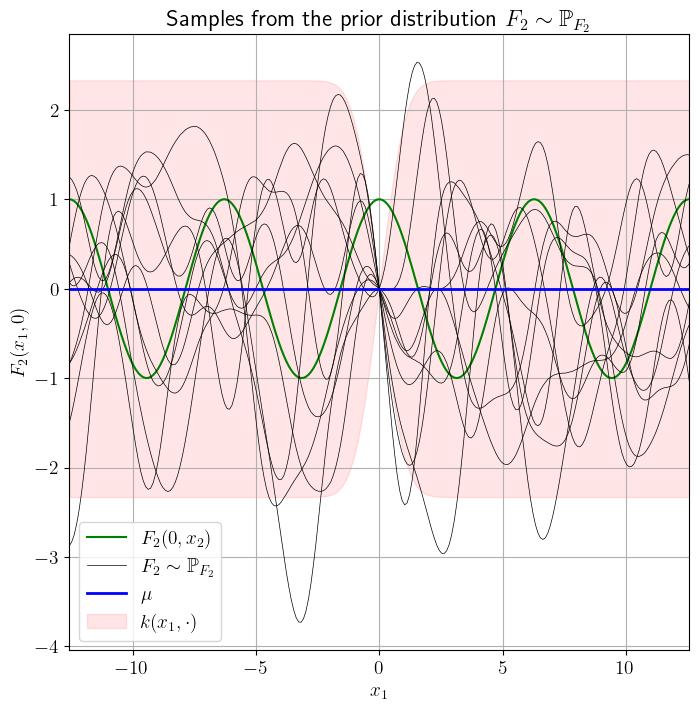

In [61]:
# Plot the samples from the prior
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
# noinspection PyRedeclaration
ax = plt.subplot(111)
ax.plot(matrix_mesh_x2[:, x1_slice],
        array_df_dx1_slice[:, random_vector_field_id],
        color="g",
label="$F_2(0, x_2)$"
        )
ax.plot(matrix_mesh_x2[:, x1_slice],
        array3d_samples_prior[:, :, 0].T,
        color="k",
        linewidth=0.5,
        label=[r"$F_2 \sim \mathbb{P}_{F_2}$"] + [None] * (n_samples_prior - 1))
# Plot the mean operator and the variance operator
ax.plot(matrix_mesh_x2[:, x1_slice],
        array_f1_mean_prior,
        color="b",
        linewidth=2,
        label=r"$\mu$")

ax.fill_between(matrix_mesh_x2[:, x1_slice],
                array_f1_mean_prior[:, 0] - 2.33 * np.sqrt(array_f1_var_prior[:, 0]),
                array_f1_mean_prior[:, 0] + 2.33 * np.sqrt(array_f1_var_prior[:, 0]),
                alpha=0.1,
                color="r",
                label=r"$k(x_1, \cdot)$")
# Set the labels
ax.set_xlabel(f"$x_1$")
ax.set_ylabel(f"$F_2(x_1, {x1_slice})$")
ax.set_xlim([x2_min, x2_max])
ax.grid(True)
# Title of the plot
ax.set_title("Samples from the prior distribution $F_2 \sim \mathbb{P}_{F_2}$")
# Display the legend
ax.legend()

# Save figure to file
# Create the folder if it does not exist
path_folder_file = pathlib.Path(f"{path_folder_figures}/prior_samples")
pathlib.Path(path_folder_file).mkdir(parents=True, exist_ok=True)
# fig.savefig(f"{path_folder_figures}/prior_samples/"
#             f"prior_samples_mean_cov.png", dpi=300)

del fig, ax

In [62]:
opt = gpflow.optimizers.Scipy()
opt.minimize(model_prior.training_loss, model_prior.trainable_variables)

      fun: -5.988810861158713
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00000000e+00,  7.77933823e-08,  5.80679074e-06])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 11
      nit: 4
     njev: 11
   status: 0
  success: True
        x: array([  0.54132485, -29.49156108, -25.17883412])

In [63]:
# Draw samples from the posterior
model_posterior = gpflow.models.GPR(
    data=(array_x1_training[:, None], array_y1_training[:, None]),
    kernel=gpflow.kernels.SquaredExponential(), 
    # noise_variance=vector_field_noise_std ** 2
    noise_variance=2 * 1e-6
)

In [64]:
array_f1_mean, array_f1_var = model_posterior.predict_f(matrix_mesh_x2[:, x1_slice, None])
array_y1_mean, array_y1_var = model_posterior.predict_y(matrix_mesh_x2[:, x1_slice, None])
# Cast to numpy array
array_f1_mean = array_f1_mean.numpy()
array_f1_var = array_f1_var.numpy()

array_upper_bound_f1 = array_f1_mean + 10. * np.sqrt(array_f1_var)
array_lower_bound_f1 = array_f1_mean - 10. * np.sqrt(array_f1_var)

n_samples_posterior = 10

array3d_samples_posterior = model_posterior.predict_f_samples(matrix_mesh_x2[:, x1_slice, None],
                                                              num_samples=n_samples_posterior).numpy()

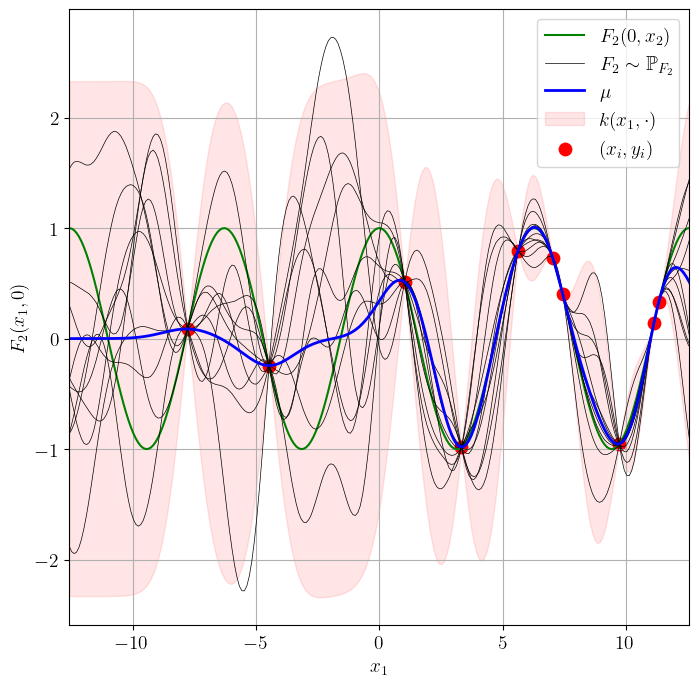

In [65]:
# Plot the results
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
# noinspection PyRedeclaration
ax = plt.subplot(111)
ax.plot(matrix_mesh_x2[:, x1_slice],
        array_df_dx1_slice[:, random_vector_field_id],
        color="g",
        label="$F_2(0, x_2)$"
        )
ax.plot(matrix_mesh_x2[:, x1_slice],
        array3d_samples_posterior[:, :, 0].T,
        color="k",
        linewidth=0.5,
        label=[r"$F_2 \sim \mathbb{P}_{F_2}$"] + [None] * (n_samples_posterior - 1))
# Plot the mean operator and the variance operator
ax.plot(matrix_mesh_x2[:, x1_slice],
        array_f1_mean,
        color="b",
        linewidth=2,
        label=r"$\mu$")
ax.fill_between(matrix_mesh_x2[:, x1_slice],
                array_f1_mean[:, 0] - 2.33 * np.sqrt(array_f1_var[:, 0]),
                array_f1_mean[:, 0] + 2.33 * np.sqrt(array_f1_var[:, 0]),
                alpha=0.1,
                color="r",
                label=r"$k(x_1, \cdot)$")
# Plot the training points
ax.scatter(array_x1_training,
           array_y1_training,
           color='r',
           s=80,
           label="$(x_i, y_i)$")
# Set the labels
ax.set_xlabel(f"$x_1$")
ax.set_ylabel(f"$F_2(x_1, {x1_slice})$")
ax.set_xlim([x2_min, x2_max])
ax.grid(True)
ax.legend()

# Save figure to file
# Create the folder if it does not exist
path_folder_file = pathlib.Path(f"{path_folder_figures}/posterior_samples")
pathlib.Path(path_folder_file).mkdir(parents=True, exist_ok=True)
# fig.savefig(f"{path_folder_figures}/posterior_samples/"
#             f"posterior_samples_mean_cov.png", dpi=300)

del fig, ax

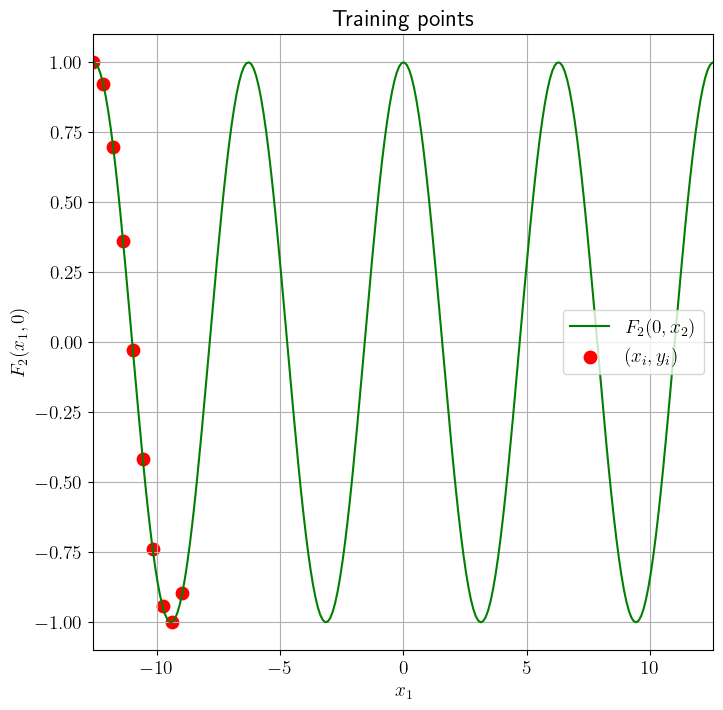

In [83]:
# Repeat the above experiment with training points that are the first 10 points of the x2 = 1 slice of the vector field
# Plot the training points
spacing_between_training_points = 4
array_training_points_new_id = np.arange(10) * spacing_between_training_points
array_x1_training_new = matrix_mesh_x2[array_training_points_new_id, x1_slice]
array_y1_training_new = array_df_dx1_slice[array_training_points_new_id, random_vector_field_id]

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
# noinspection PyRedeclaration
ax = plt.subplot(111)
ax.plot(matrix_mesh_x2[:, x1_slice],
        array_df_dx1_slice[:, random_vector_field_id],
        color="g",
        label="$F_2(0, x_2)$")
ax.scatter(array_x1_training_new,
           array_y1_training_new,
           color='r',
           s=80,
           label="$(x_i, y_i)$")
# Set the labels
ax.set_xlabel(f"$x_1$")
ax.set_ylabel(f"$F_2(x_1, {x1_slice})$")
ax.set_xlim([x2_min, x2_max])
ax.grid(True)
# Title of the plot
ax.set_title("Training points")
# Display the legend
ax.legend()

del fig, ax

In [84]:
# Draw samples from the posterior
model_posterior_new = gpflow.models.GPR(
    data=(array_x1_training_new[:, None], array_y1_training_new[:, None]),
    kernel=gpflow.kernels.SquaredExponential(),
    noise_variance=2 * 1e-6
)

array_f1_mean_new, array_f1_var_new = model_posterior_new.predict_f(matrix_mesh_x2[:, x1_slice, None])
array_y1_mean_new, array_y1_var_new = model_posterior_new.predict_y(matrix_mesh_x2[:, x1_slice, None])
# Cast to numpy array
array_f1_mean_new = array_f1_mean_new.numpy()
array_f1_var_new = array_f1_var_new.numpy()

array_upper_bound_f1_new = array_f1_mean_new + 10. * np.sqrt(array_f1_var_new)
array_lower_bound_f1_new = array_f1_mean_new - 10. * np.sqrt(array_f1_var_new)


array3d_samples_posterior_new = model_posterior_new.predict_f_samples(matrix_mesh_x2[:, x1_slice, None],
                                                                      num_samples=n_samples_posterior).numpy()

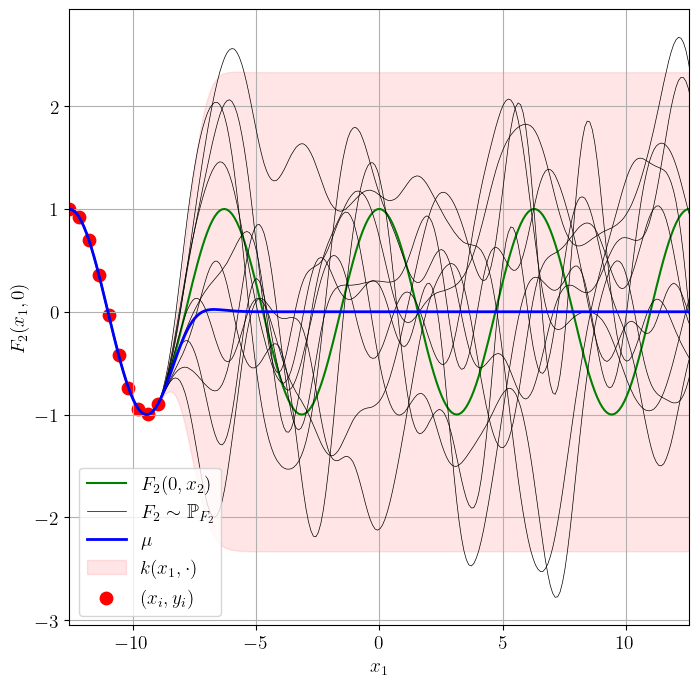

In [85]:
# Plot the results
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
# noinspection PyRedeclaration
ax = plt.subplot(111)
ax.plot(matrix_mesh_x2[:, x1_slice],
        array_df_dx1_slice[:, random_vector_field_id],
        color="g",
        label="$F_2(0, x_2)$"
        )
ax.plot(matrix_mesh_x2[:, x1_slice],
        array3d_samples_posterior_new[:, :, 0].T,
        color="k",
        linewidth=0.5,
        label=[r"$F_2 \sim \mathbb{P}_{F_2}$"] + [None] * (n_samples_posterior - 1))
# Plot the mean operator and the variance operator
ax.plot(matrix_mesh_x2[:, x1_slice],
        array_f1_mean_new,
        color="b",
        linewidth=2,
        label=r"$\mu$")
ax.fill_between(matrix_mesh_x2[:, x1_slice],
                array_f1_mean_new[:, 0] - 2.33 * np.sqrt(array_f1_var_new[:, 0]),
                array_f1_mean_new[:, 0] + 2.33 * np.sqrt(array_f1_var_new[:, 0]),
                alpha=0.1,
                color="r",
                label=r"$k(x_1, \cdot)$")
# Plot the training points
ax.scatter(array_x1_training_new,
           array_y1_training_new,
           color='r',
           s=80,
           label="$(x_i, y_i)$")
# Set the labels
ax.set_xlabel(f"$x_1$")
ax.set_ylabel(f"$F_2(x_1, {x1_slice})$")
ax.set_xlim([x2_min, x2_max])
ax.grid(True)
ax.legend()
